In [1]:
# coding=utf-8
# Copyright (c) 2023 Ira Shokar
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import notebook_utils, utils, SLT                      # import modules
import matplotlib.pyplot as plt, numpy as np, torch    # import packages

## Load Trained SLT and Integrate Forward

In [2]:
# Define Parameters
LATENT_DIM = 64 
SEQ_LENGTH = 10

AE    = SLT.load_model('AE'   , LATENT_DIM)
Trans = SLT.load_model('Trans', LATENT_DIM)

time_step_start = 100
ensemble_size   = 8
evolution_time  = 500

truth_ens = utils.truth_ensemble(
    SEQ_LENGTH, evolution_time, ensemble_size, time_step_start
    )

truth_ens, preds_ens, att = SLT.SLT_prediction_ensemble(
    AE, Trans, SEQ_LENGTH, LATENT_DIM, truth_ens, evolution_time
    )

## Plot Latitude-Time Plots for the numerical integration and Stochatic Latent Transformer

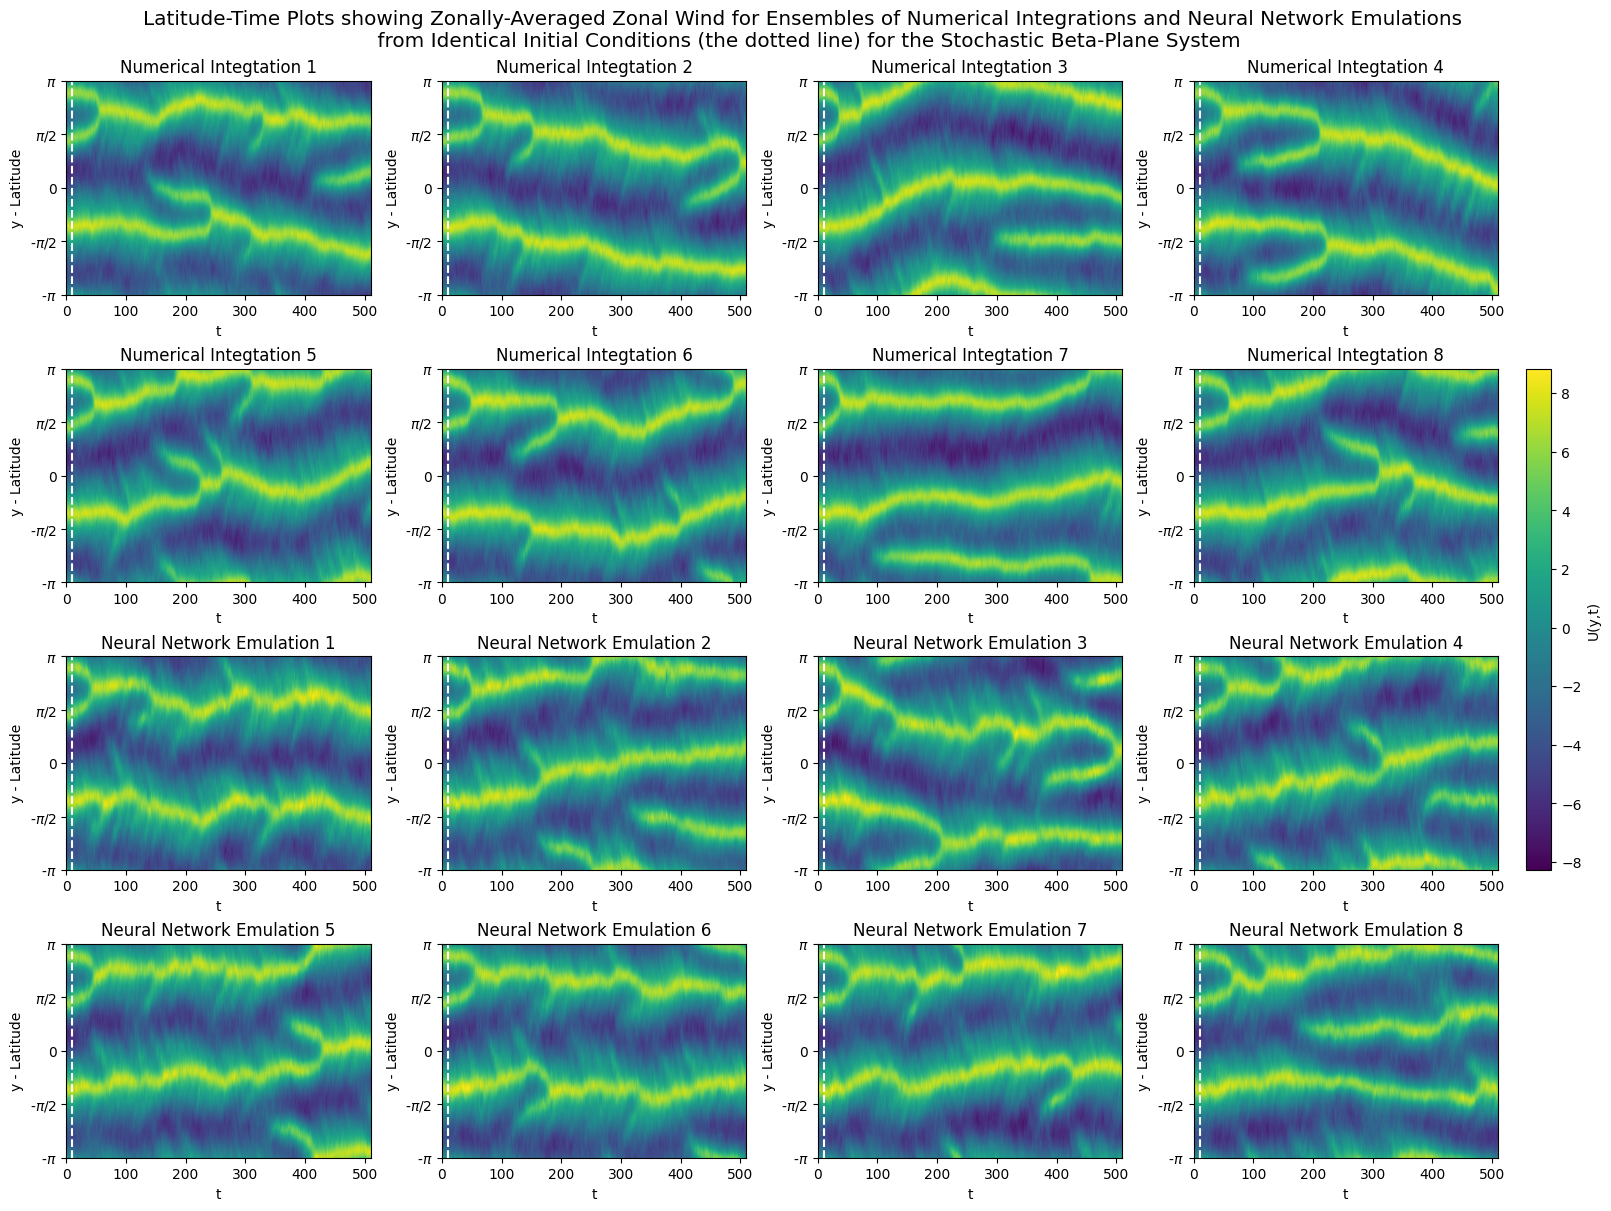

In [3]:
utils.plot_ensembles(truth_ens, preds_ens, seq_len=SEQ_LENGTH, damping_time=False, show=True)

## Plot PDFs for the numerical integration and Stochatic Latent Transformer

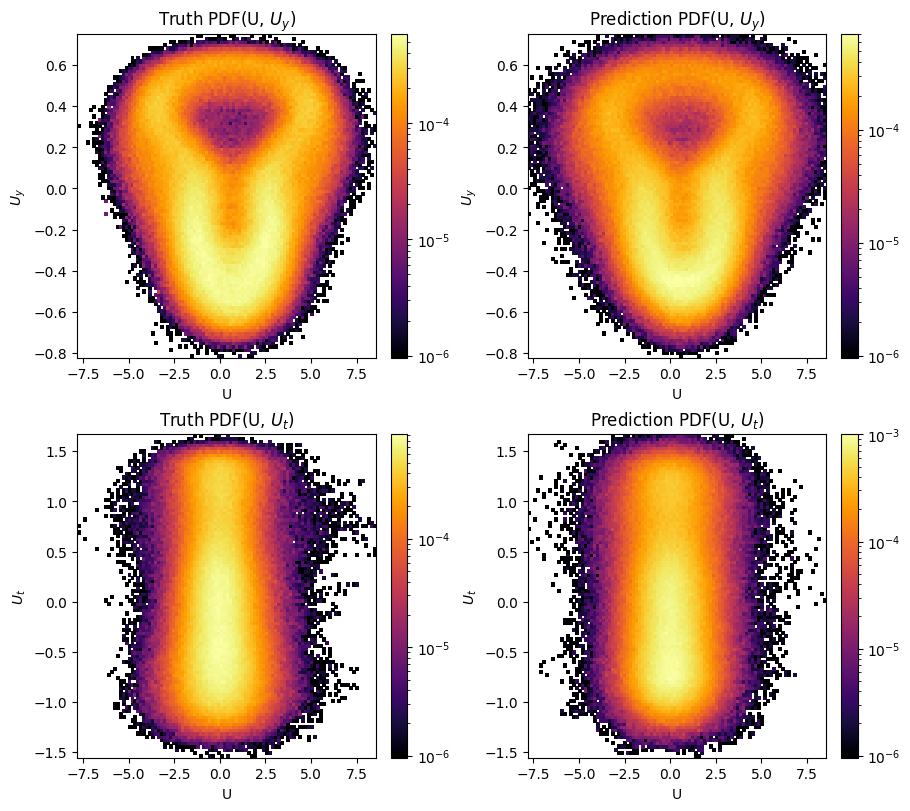

In [4]:
truth_mat, preds_mat = utils.calculate_grad_fields(truth_ens, preds_ens)
p, q, e              = utils.calculate_pdfs(truth_mat, preds_mat)
utils.plot_pdf(p, q, e)

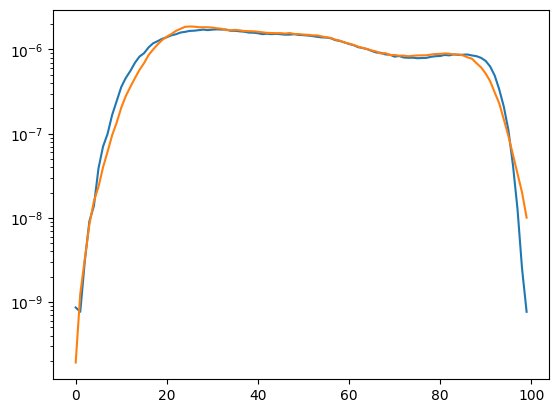

In [7]:
plt.plot(p.mean(axis=(1,2)))
plt.plot(q.mean(axis=(1,2)))
plt.yscale('log')

## Plot Latitudinal Kinetitc Energy for the numerical integration and Stochatic Latent Transformer

In [ ]:
truth_ens_energy = torch.mean(torch.mean(truth_ens**2, dim=-1), dim=0)
preds_ens_energy = torch.mean(torch.mean(preds_ens**2, dim=-1), dim=0)

plt.figure(figsize=(15, 2), dpi=300)
plt.plot(truth_ens_energy.cpu(), label='Num Int')
plt.plot(preds_ens_energy.cpu(), label='ML' )
plt.ylabel('Kinetic Energy')
plt.xlabel('t')
plt.legend()
plt.ylim(0, 20)
plt.xlim(0, 500)

### Visualise Translational Equivariance properties of Encoder (Approximate due to discretisation)

In [ ]:
truth_ens = utils.truth_ensemble(1, 100, 1, 100)

def remove_phase(z):

    z   = torch.fft.rfft(z, norm='ortho')
    N = z.size(-1)
    k = torch.linspace(-(N-1)//2, (N-1)//2, N).to(z.device)
    k = torch.cat((k[(N-1)//2:], k[:(N-1)//2]))
    phi = torch.angle(z[...,1])
    phi = torch.einsum('i,k->ik', phi, k)
    z   = z * torch.exp(-1j*phi)
    z   = torch.fft.irfft(z, norm='ortho')
    return z

shift_by      = 8
shift_by_in_z = int(shift_by * LATENT_DIM / 256)

with torch.no_grad():

    a = remove_phase(AE.Encoder(truth_ens[0, 0].unsqueeze(0)))[0]
    b = remove_phase(AE.Encoder(torch.roll(truth_ens[0, 0], shift_by_in_z).unsqueeze(0)))[0]

plt.plot(a.cpu().numpy(), label='z')
plt.plot(b.cpu().numpy(), label='z_plus_phase')
plt.legend()
plt.show()